In [1]:
# ----------------------------------------------------------------------------*
# SEIS 764 Artificial Intelligence
# Assignment 6 :  RNN, LSTM, GRU
# auther: Yann Mulonda - November 20, 2021
# ----------------------------------------------------------------------------*
# Import the libraries needed
import numpy as np
import pandas as pd
from glob import glob
import sys, os, zipfile
import tensorflow as tf
from google.colab import auth
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from oauth2client.client import GoogleCredentials
from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten

In [2]:
# check which runtime GPU I'm using
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# ----------------------------------------------------------------------------*
def datasetInfo(data):
  # show dataset info
  print(data.info())
  # show dataset info - describe dataset
  print(data.describe())
  # show dataset info - top 10 rows
  print(data.head(10))

In [4]:
# ----------------------------------------------------------------------------*
# Download the data file saved in the Drive 
!pip install -U -q PyDrive

#File ID
file_id = '1WxkT_jgBlScTZVEmdE27VI0Bq0GPazyY'

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the humidity.csv file
downloaded = drive.CreateFile({'id':file_id})   
downloaded.GetContentFile('humidity.csv')   

In [5]:
# Get and Read data
data = pd.read_csv('humidity.csv')
datasetInfo(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   humidity  3650 non-null   float64
dtypes: float64(1)
memory usage: 28.6 KB
None
          humidity
count  3650.000000
mean     11.177753
std       4.071837
min       0.000000
25%       8.300000
50%      11.000000
75%      14.000000
max      26.300000
   humidity
0      20.7
1      17.9
2      18.8
3      14.6
4      15.8
5      15.8
6      15.8
7      17.4
8      21.8
9      20.0


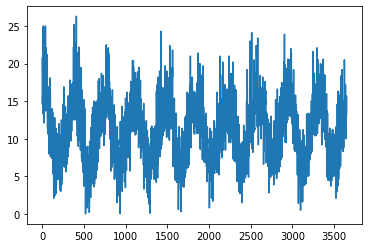

(3650,)

In [11]:
# plot it
#Generating synthetic data of the form sin(kt^2)
humidity_data = data['humidity']
# series = np.sin(humidity_data**2)
series = humidity_data
plt.plot(series)
plt.show()

series.shape

In [12]:
# Build the dataset
# We will use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (3640, 10, 1) Y.shape (3640,)


In [14]:
#Build the Simple RNN Model
i = Input(shape=(T, 1))

# chang the number of unit has a insignificant impact on the model result
# x = SimpleRNN(5)(i)
x = SimpleRNN(15)(i)

# the model is not doing well with relu activation
# x = SimpleRNN(15,activation='relu')(i)  

x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(learning_rate=0.001),
)

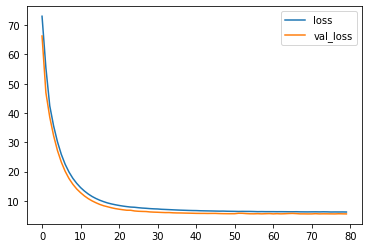

In [15]:
# train the Model
r = model.fit(
  X[:N//2], Y[:N//2],
  epochs=80,
  validation_data=(X[N//2:], Y[N//2:]),
  verbose=0,
)

# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

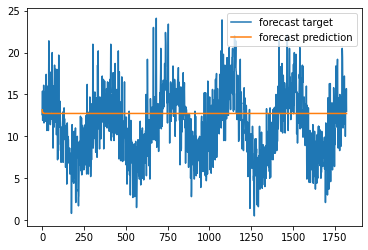

In [16]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[N//2:]
validation_predictions = []

# first validation input
last_x = X[N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()